<a href="https://colab.research.google.com/github/CharlyMech/IEDIB_CEIA_2024-25/blob/main/Sistemas%20de%20Aprendizaje%20automatico/Bloque%207/Actividades/7.1/sanchezrecio_carlos_task7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluated task CE_5072 7.1

For this task I will just be modifying the first part of the article to save a little bit of time. This task will have 2 parts:

- Increasing parameters to make the model be more precise to the prompts (more time consuming).

- Decrease parameters to make the model less precise to the prompts (less time consuming).

# Changes made:

- **Re-write the prompts:** force or not the model to interpolate between radically different visual styles and elements.

- **Increase/Decrease the `guidance_scale`:** this will make the model follow closer or not to the prompts.

- **Increase/Decrease the `interpolation_steps`:** this will make create a smother or less smooth gradual evolution.

In [ ]:
!# Use the latest version of KerasHub
!!pip install -Uq git+https://github.com/keras-team/keras-hub.git

['  Installing build dependencies ... \x1b[?25l\x1b[?25hdone',
 '  Getting requirements to build wheel ... \x1b[?25l\x1b[?25hdone',
 '  Preparing metadata (pyproject.toml) ... \x1b[?25l\x1b[?25hdone',
 '  Building wheel for keras-hub (pyproject.toml) ... \x1b[?25l\x1b[?25hdone',
 "\x1bERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.",
 'keras-nlp 0.18.1 requires keras-hub==0.18.1, but you have keras-hub 0.21.0.dev0 which is incompatible.\x1b\x1b',
 '\x1b']

# More precise interpolation

In [ ]:
import math
import keras
import keras_hub
import matplotlib.pyplot as plt
from keras import ops
from keras import random
from PIL import Image

height, width = 512, 512
num_steps = 28
guidance_scale = 10.0 # Increase this value to be closer to the prompt (7.0 -> 10.0)
dtype = "float16"

# Instantiate the Stable Diffusion 3 model and the preprocessor
backbone = keras_hub.models.StableDiffusion3Backbone.from_preset(
    "stable_diffusion_3_medium", image_shape=(height, width, 3), dtype=dtype
)
preprocessor = keras_hub.models.StableDiffusion3TextToImagePreprocessor.from_preset(
    "stable_diffusion_3_medium"
)

In [ ]:
def get_text_embeddings(prompt):
    """Get the text embeddings for a given prompt."""
    token_ids = preprocessor.generate_preprocess([prompt])
    negative_token_ids = preprocessor.generate_preprocess([""])
    (
        positive_embeddings,
        negative_embeddings,
        positive_pooled_embeddings,
        negative_pooled_embeddings,
    ) = backbone.encode_text_step(token_ids, negative_token_ids)
    return (
        positive_embeddings,
        negative_embeddings,
        positive_pooled_embeddings,
        negative_pooled_embeddings,
    )


def decode_to_images(x, height, width):
    """Concatenate and normalize the images to uint8 dtype."""
    x = ops.concatenate(x, axis=0)
    x = ops.reshape(x, (-1, height, width, 3))
    x = ops.clip(ops.divide(ops.add(x, 1.0), 2.0), 0.0, 1.0)
    return ops.cast(ops.round(ops.multiply(x, 255.0)), "uint8")


def generate_with_latents_and_embeddings(
    latents, embeddings, num_steps, guidance_scale
):
    """Generate images from latents and text embeddings."""

    def body_fun(step, latents):
        return backbone.denoise_step(
            latents,
            embeddings,
            step,
            num_steps,
            guidance_scale,
        )

    latents = ops.fori_loop(0, num_steps, body_fun, latents)
    return backbone.decode_step(latents)


def export_as_gif(filename, images, frames_per_second=10, no_rubber_band=False):
    if not no_rubber_band:
        images += images[2:-1][::-1]  # Makes a rubber band: A->B->A
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )


In [ ]:
if keras.config.backend() == "torch":
    import torch

    @torch.no_grad()
    def wrapped_function(*args, **kwargs):
        return generate_with_latents_and_embeddings(*args, **kwargs)

    generate_function = wrapped_function
elif keras.config.backend() == "tensorflow":
    import tensorflow as tf

    generate_function = tf.function(
        generate_with_latents_and_embeddings, jit_compile=True
    )
elif keras.config.backend() == "jax":
    import itertools

    import jax

    @jax.jit
    def compiled_function(state, *args, **kwargs):
        (trainable_variables, non_trainable_variables) = state
        mapping = itertools.chain(
            zip(backbone.trainable_variables, trainable_variables),
            zip(backbone.non_trainable_variables, non_trainable_variables),
        )
        with keras.StatelessScope(state_mapping=mapping):
            return generate_with_latents_and_embeddings(*args, **kwargs)

    def wrapped_function(*args, **kwargs):
        state = (
            [v.value for v in backbone.trainable_variables],
            [v.value for v in backbone.non_trainable_variables],
        )
        return compiled_function(state, *args, **kwargs)

    generate_function = wrapped_function


In [ ]:
prompt_1 = "A cute dog in a beautiful field of lavander colorful flowers "
prompt_1 += "everywhere, perfect lighting, leica summicron 35mm f2.0, kodak "
prompt_1 += "portra 400, film grain"
prompt_2 = prompt_1.replace("dog", "cat")
interpolation_steps = 8 # Increase this value (5 -> 8)

encoding_1 = get_text_embeddings(prompt_1)
encoding_2 = get_text_embeddings(prompt_2)


# Show the size of the latent manifold
print(f"Positive embeddings shape: {encoding_1[0].shape}")
print(f"Negative embeddings shape: {encoding_1[1].shape}")
print(f"Positive pooled embeddings shape: {encoding_1[2].shape}")
print(f"Negative pooled embeddings shape: {encoding_1[3].shape}")


Positive embeddings shape: (1, 154, 4096)
Negative embeddings shape: (1, 154, 4096)
Positive pooled embeddings shape: (1, 2048)
Negative pooled embeddings shape: (1, 2048)


In [ ]:
def slerp(v1, v2, num):
    ori_dtype = v1.dtype
    # Cast to float32 for numerical stability.
    v1 = ops.cast(v1, "float32")
    v2 = ops.cast(v2, "float32")

    def interpolation(t, v1, v2, dot_threshold=0.9995):
        """helper function to spherically interpolate two arrays."""
        dot = ops.sum(
            v1 * v2 / (ops.linalg.norm(ops.ravel(v1)) * ops.linalg.norm(ops.ravel(v2)))
        )
        if ops.abs(dot) > dot_threshold:
            v2 = (1 - t) * v1 + t * v2
        else:
            theta_0 = ops.arccos(dot)
            sin_theta_0 = ops.sin(theta_0)
            theta_t = theta_0 * t
            sin_theta_t = ops.sin(theta_t)
            s0 = ops.sin(theta_0 - theta_t) / sin_theta_0
            s1 = sin_theta_t / sin_theta_0
            v2 = s0 * v1 + s1 * v2
        return v2

    t = ops.linspace(0, 1, num)
    interpolated = ops.stack([interpolation(t[i], v1, v2) for i in range(num)], axis=0)
    return ops.cast(interpolated, ori_dtype)


interpolated_positive_embeddings = slerp(
    encoding_1[0], encoding_2[0], interpolation_steps
)
interpolated_positive_pooled_embeddings = slerp(
    encoding_1[2], encoding_2[2], interpolation_steps
)
# We don't use negative prompts in this example, so there’s no need to
# interpolate them.
negative_embeddings = encoding_1[1]
negative_pooled_embeddings = encoding_1[3]


In [ ]:
latents = random.normal((1, height // 8, width // 8, 16), seed=42)

images = []
progbar = keras.utils.Progbar(interpolation_steps)
for i in range(interpolation_steps):
    images.append(
        generate_function(
            latents,
            (
                interpolated_positive_embeddings[i],
                negative_embeddings,
                interpolated_positive_pooled_embeddings[i],
                negative_pooled_embeddings,
            ),
            ops.convert_to_tensor(num_steps),
            ops.convert_to_tensor(guidance_scale),
        )
    )
    progbar.update(i + 1, finalize=i == interpolation_steps - 1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 104s 8s/step


In [ ]:
images = ops.convert_to_numpy(decode_to_images(images, height, width))
export_as_gif(
    "dog_to_cat_5.gif",
    [Image.fromarray(image) for image in images],
    frames_per_second=2,
)

In [ ]:
interpolation_steps = 64
batch_size = 4
batches = interpolation_steps // batch_size

interpolated_positive_embeddings = slerp(
    encoding_1[0], encoding_2[0], interpolation_steps
)
interpolated_positive_pooled_embeddings  = slerp(
    encoding_1[2], encoding_2[2], interpolation_steps
)
positive_embeddings_shape = ops.shape(encoding_1[0])
positive_pooled_embeddings_shape = ops.shape(encoding_1[2])
interpolated_positive_embeddings = ops.reshape(
    interpolated_positive_embeddings,
    (
        batches,
        batch_size,
        positive_embeddings_shape[-2],
        positive_embeddings_shape[-1],
    ),
)
interpolated_positive_pooled_embeddings = ops.reshape(
    interpolated_positive_pooled_embeddings,
    (batches, batch_size, positive_pooled_embeddings_shape[-1]),
)
negative_embeddings = ops.tile(encoding_1[1], (batch_size, 1, 1))
negative_pooled_embeddings = ops.tile(encoding_1[3], (batch_size, 1))

latents = random.normal((1, height // 8, width // 8, 16), seed=42)
latents = ops.tile(latents, (batch_size, 1, 1, 1))

images = []
progbar = keras.utils.Progbar(batches)
for i in range(batches):
    images.append(
        generate_function(
            latents,
            (
                interpolated_positive_embeddings[i],
                negative_embeddings,
                interpolated_positive_pooled_embeddings[i],
                negative_pooled_embeddings,
            ),
            ops.convert_to_tensor(num_steps),
            ops.convert_to_tensor(guidance_scale),
        )
    )
    progbar.update(i + 1, finalize=i == batches - 1)

images = ops.convert_to_numpy(decode_to_images(images, height, width))
export_as_gif(
    "dog_to_cat_64.gif",
    [Image.fromarray(image) for image in images],
    frames_per_second=2,
)

16/16 ━━━━━━━━━━━━━━━━━━━━ 665s 35s/step


In [ ]:
# Original prompts
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
prompt_3 = "The eiffel tower in the style of starry night"
prompt_4 = "An architectural sketch of a skyscraper"

# New richer prompts
carlos_prompt_1 = "A Staffy painted as a muscular human if it was painted by Salvador dalí with several retro styled spaceships behind in pixelart"
carlos_prompt_2 = "An aesthetic picture of a bowl with plenty of fruit with black and white filter in a cloudy day at the window behind"
carlos_prompt_3 = "The EmpireState Building if it was created by the same architec as the Sagrada Familia from Barcelona with the starry night"
carlos_prompt_4 = "The structural schema of an atom if it was painted and sketched by the egyptian empire"

interpolation_steps = 8
batch_size = 4
batches = (interpolation_steps**2) // batch_size

''' OLD
encoding_1 = get_text_embeddings(prompt_1)
encoding_2 = get_text_embeddings(prompt_2)
encoding_3 = get_text_embeddings(prompt_3)
encoding_4 = get_text_embeddings(prompt_4)
'''
encoding_1 = get_text_embeddings(carlos_prompt_1)
encoding_2 = get_text_embeddings(carlos_prompt_2)
encoding_3 = get_text_embeddings(carlos_prompt_3)
encoding_4 = get_text_embeddings(carlos_prompt_4)

positive_embeddings_shape = ops.shape(encoding_1[0])
positive_pooled_embeddings_shape = ops.shape(encoding_1[2])
interpolated_positive_embeddings_12 = slerp(
    encoding_1[0], encoding_2[0], interpolation_steps
)
interpolated_positive_embeddings_34 = slerp(
    encoding_3[0], encoding_4[0], interpolation_steps
)
interpolated_positive_embeddings = slerp(
    interpolated_positive_embeddings_12,
    interpolated_positive_embeddings_34,
    interpolation_steps,
)
interpolated_positive_embeddings = ops.reshape(
    interpolated_positive_embeddings,
    (
        batches,
        batch_size,
        positive_embeddings_shape[-2],
        positive_embeddings_shape[-1],
    ),
)
interpolated_positive_pooled_embeddings_12 = slerp(
    encoding_1[2], encoding_2[2], interpolation_steps
)
interpolated_positive_pooled_embeddings_34 = slerp(
    encoding_3[2], encoding_4[2], interpolation_steps
)
interpolated_positive_pooled_embeddings = slerp(
    interpolated_positive_pooled_embeddings_12,
    interpolated_positive_pooled_embeddings_34,
    interpolation_steps,
)
interpolated_positive_pooled_embeddings = ops.reshape(
    interpolated_positive_pooled_embeddings,
    (batches, batch_size, positive_pooled_embeddings_shape[-1]),
)
negative_embeddings = ops.tile(encoding_1[1], (batch_size, 1, 1))
negative_pooled_embeddings = ops.tile(encoding_1[3], (batch_size, 1))

latents = random.normal((1, height // 8, width // 8, 16), seed=42)
latents = ops.tile(latents, (batch_size, 1, 1, 1))

images = []
progbar = keras.utils.Progbar(batches)
for i in range(batches):
    images.append(
        generate_function(
            latents,
            (
                interpolated_positive_embeddings[i],
                negative_embeddings,
                interpolated_positive_pooled_embeddings[i],
                negative_pooled_embeddings,
            ),
            ops.convert_to_tensor(num_steps),
            ops.convert_to_tensor(guidance_scale),
        )
    )
    progbar.update(i + 1, finalize=i == batches - 1)


16/16 ━━━━━━━━━━━━━━━━━━━━ 554s 35s/step


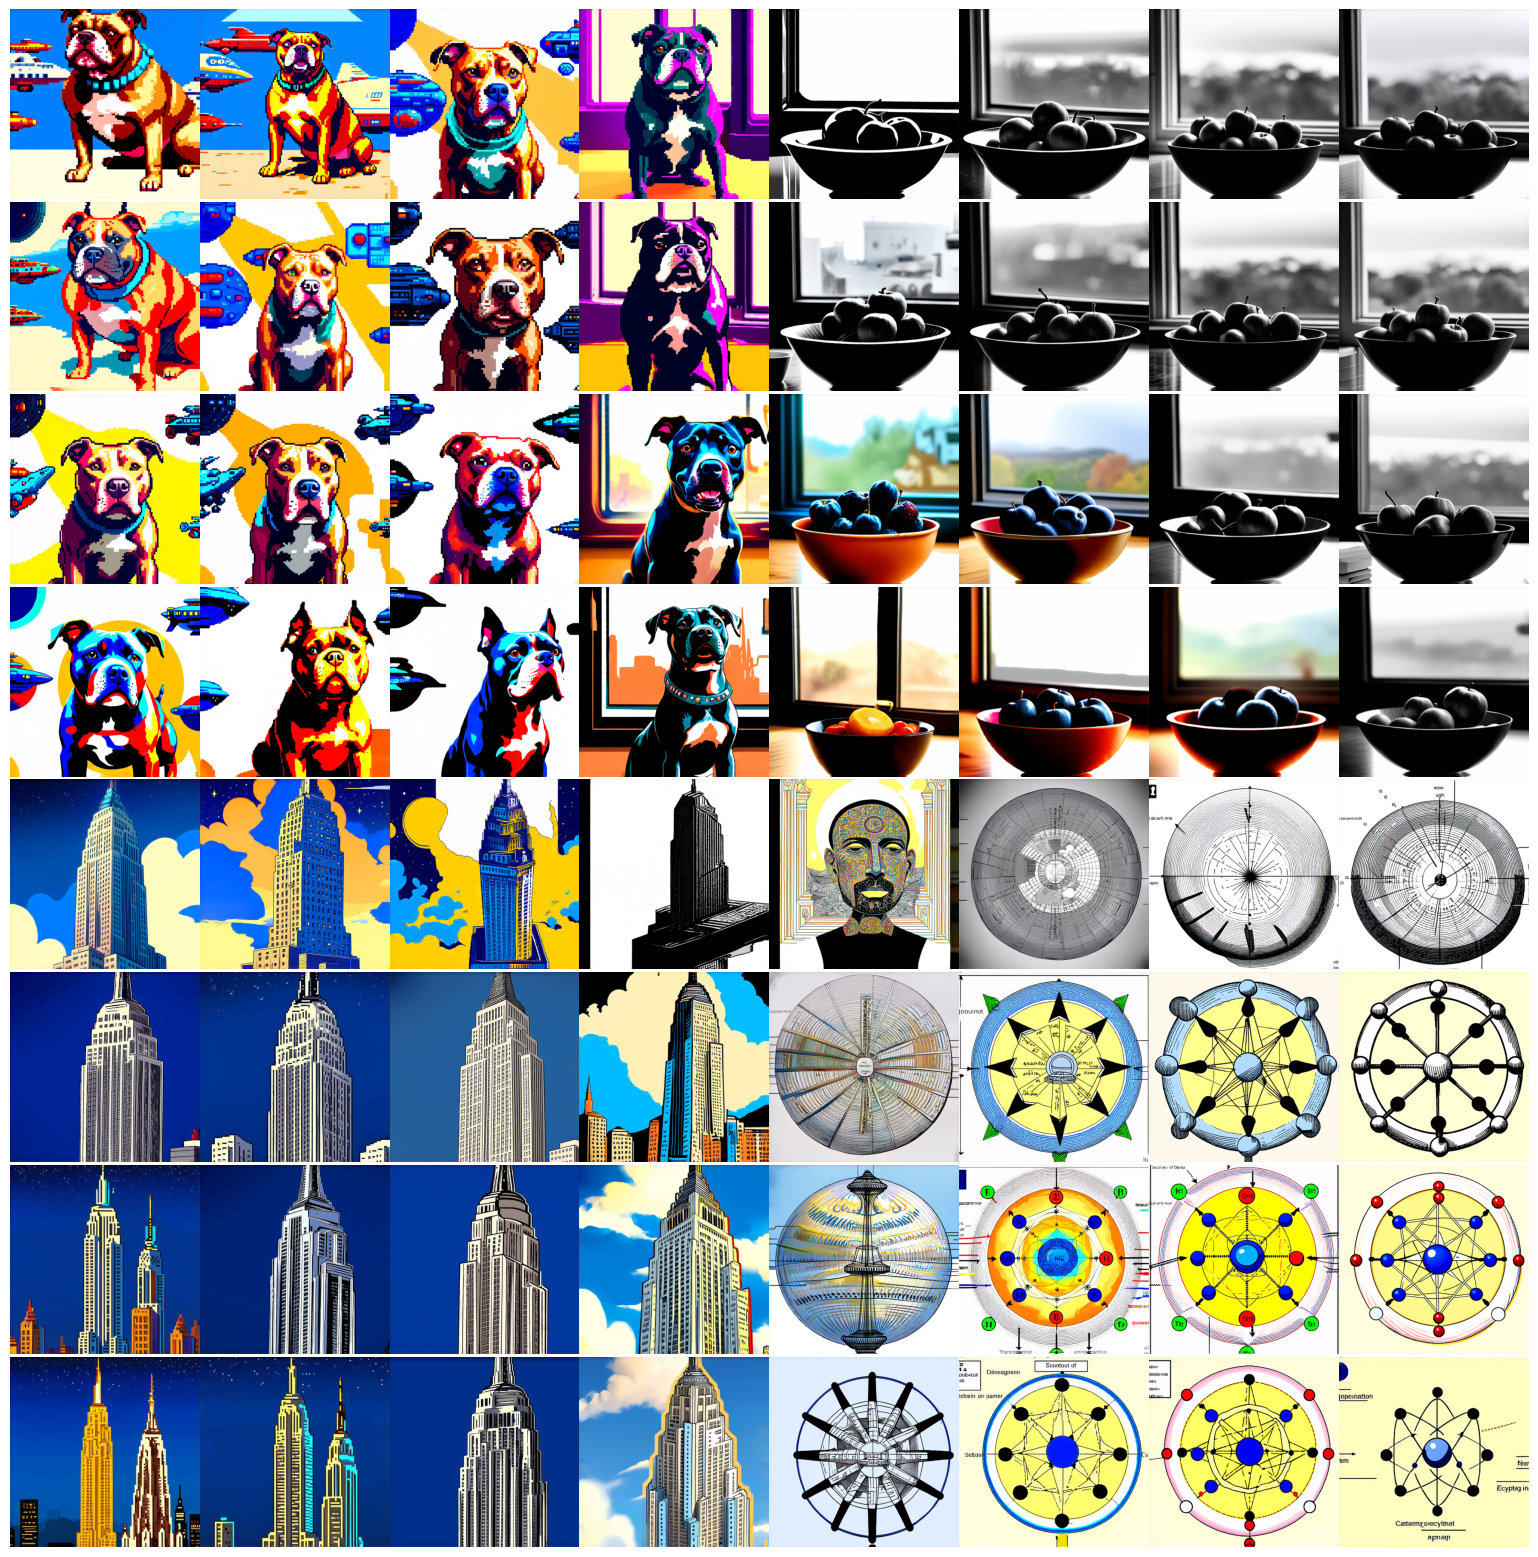

In [ ]:
def plot_grid(images, path, grid_size, scale=2):
    fig, axs = plt.subplots(
        grid_size, grid_size, figsize=(grid_size * scale, grid_size * scale)
    )
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis("off")
    for ax in axs.flat:
        ax.axis("off")

    for i in range(min(grid_size * grid_size, len(images))):
        ax = axs.flat[i]
        ax.imshow(images[i])
        ax.axis("off")

    for i in range(len(images), grid_size * grid_size):
        axs.flat[i].axis("off")
        axs.flat[i].remove()

    plt.savefig(
        fname=path,
        pad_inches=0,
        bbox_inches="tight",
        transparent=False,
        dpi=60,
    )


images = ops.convert_to_numpy(decode_to_images(images, height, width))
plot_grid(images, "4-way-interpolation.jpg", interpolation_steps)

# Less precise interpolation

In [1]:
import math
import keras
import keras_hub
import matplotlib.pyplot as plt
from keras import ops
from keras import random
from PIL import Image

height, width = 512, 512
num_steps = 28
guidance_scale = 5.0 # Decrease this value to be closer to the prompt (7.0 -> 50.0)
dtype = "float16"

# Instantiate the Stable Diffusion 3 model and the preprocessor
backbone = keras_hub.models.StableDiffusion3Backbone.from_preset(
    "stable_diffusion_3_medium", image_shape=(height, width, 3), dtype=dtype
)
preprocessor = keras_hub.models.StableDiffusion3TextToImagePreprocessor.from_preset(
    "stable_diffusion_3_medium"
)

100%|██████████| 3.07k/3.07k [00:00<00:00, 6.02MB/s]


100%|██████████| 5.57G/5.57G [06:18<00:00, 15.8MB/s]


In [2]:
def get_text_embeddings(prompt):
    """Get the text embeddings for a given prompt."""
    token_ids = preprocessor.generate_preprocess([prompt])
    negative_token_ids = preprocessor.generate_preprocess([""])
    (
        positive_embeddings,
        negative_embeddings,
        positive_pooled_embeddings,
        negative_pooled_embeddings,
    ) = backbone.encode_text_step(token_ids, negative_token_ids)
    return (
        positive_embeddings,
        negative_embeddings,
        positive_pooled_embeddings,
        negative_pooled_embeddings,
    )


def decode_to_images(x, height, width):
    """Concatenate and normalize the images to uint8 dtype."""
    x = ops.concatenate(x, axis=0)
    x = ops.reshape(x, (-1, height, width, 3))
    x = ops.clip(ops.divide(ops.add(x, 1.0), 2.0), 0.0, 1.0)
    return ops.cast(ops.round(ops.multiply(x, 255.0)), "uint8")


def generate_with_latents_and_embeddings(
    latents, embeddings, num_steps, guidance_scale
):
    """Generate images from latents and text embeddings."""

    def body_fun(step, latents):
        return backbone.denoise_step(
            latents,
            embeddings,
            step,
            num_steps,
            guidance_scale,
        )

    latents = ops.fori_loop(0, num_steps, body_fun, latents)
    return backbone.decode_step(latents)


def export_as_gif(filename, images, frames_per_second=10, no_rubber_band=False):
    if not no_rubber_band:
        images += images[2:-1][::-1]  # Makes a rubber band: A->B->A
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )


In [3]:
if keras.config.backend() == "torch":
    import torch

    @torch.no_grad()
    def wrapped_function(*args, **kwargs):
        return generate_with_latents_and_embeddings(*args, **kwargs)

    generate_function = wrapped_function
elif keras.config.backend() == "tensorflow":
    import tensorflow as tf

    generate_function = tf.function(
        generate_with_latents_and_embeddings, jit_compile=True
    )
elif keras.config.backend() == "jax":
    import itertools

    import jax

    @jax.jit
    def compiled_function(state, *args, **kwargs):
        (trainable_variables, non_trainable_variables) = state
        mapping = itertools.chain(
            zip(backbone.trainable_variables, trainable_variables),
            zip(backbone.non_trainable_variables, non_trainable_variables),
        )
        with keras.StatelessScope(state_mapping=mapping):
            return generate_with_latents_and_embeddings(*args, **kwargs)

    def wrapped_function(*args, **kwargs):
        state = (
            [v.value for v in backbone.trainable_variables],
            [v.value for v in backbone.non_trainable_variables],
        )
        return compiled_function(state, *args, **kwargs)

    generate_function = wrapped_function


In [4]:
prompt_1 = "A cute dog in a beautiful field of lavander colorful flowers "
prompt_1 += "everywhere, perfect lighting, leica summicron 35mm f2.0, kodak "
prompt_1 += "portra 400, film grain"
prompt_2 = prompt_1.replace("dog", "cat")
interpolation_steps = 3 # Decrease this value (5 -> 3)

encoding_1 = get_text_embeddings(prompt_1)
encoding_2 = get_text_embeddings(prompt_2)


# Show the size of the latent manifold
print(f"Positive embeddings shape: {encoding_1[0].shape}")
print(f"Negative embeddings shape: {encoding_1[1].shape}")
print(f"Positive pooled embeddings shape: {encoding_1[2].shape}")
print(f"Negative pooled embeddings shape: {encoding_1[3].shape}")


Positive embeddings shape: (1, 154, 4096)
Negative embeddings shape: (1, 154, 4096)
Positive pooled embeddings shape: (1, 2048)
Negative pooled embeddings shape: (1, 2048)


In [5]:
def slerp(v1, v2, num):
    ori_dtype = v1.dtype
    # Cast to float32 for numerical stability.
    v1 = ops.cast(v1, "float32")
    v2 = ops.cast(v2, "float32")

    def interpolation(t, v1, v2, dot_threshold=0.9995):
        """helper function to spherically interpolate two arrays."""
        dot = ops.sum(
            v1 * v2 / (ops.linalg.norm(ops.ravel(v1)) * ops.linalg.norm(ops.ravel(v2)))
        )
        if ops.abs(dot) > dot_threshold:
            v2 = (1 - t) * v1 + t * v2
        else:
            theta_0 = ops.arccos(dot)
            sin_theta_0 = ops.sin(theta_0)
            theta_t = theta_0 * t
            sin_theta_t = ops.sin(theta_t)
            s0 = ops.sin(theta_0 - theta_t) / sin_theta_0
            s1 = sin_theta_t / sin_theta_0
            v2 = s0 * v1 + s1 * v2
        return v2

    t = ops.linspace(0, 1, num)
    interpolated = ops.stack([interpolation(t[i], v1, v2) for i in range(num)], axis=0)
    return ops.cast(interpolated, ori_dtype)


interpolated_positive_embeddings = slerp(
    encoding_1[0], encoding_2[0], interpolation_steps
)
interpolated_positive_pooled_embeddings = slerp(
    encoding_1[2], encoding_2[2], interpolation_steps
)
# We don't use negative prompts in this example, so there’s no need to
# interpolate them.
negative_embeddings = encoding_1[1]
negative_pooled_embeddings = encoding_1[3]


In [6]:
latents = random.normal((1, height // 8, width // 8, 16), seed=42)

images = []
progbar = keras.utils.Progbar(interpolation_steps)
for i in range(interpolation_steps):
    images.append(
        generate_function(
            latents,
            (
                interpolated_positive_embeddings[i],
                negative_embeddings,
                interpolated_positive_pooled_embeddings[i],
                negative_pooled_embeddings,
            ),
            ops.convert_to_tensor(num_steps),
            ops.convert_to_tensor(guidance_scale),
        )
    )
    progbar.update(i + 1, finalize=i == interpolation_steps - 1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 66s 9s/step


In [7]:
images = ops.convert_to_numpy(decode_to_images(images, height, width))
export_as_gif(
    "dog_to_cat_5.gif",
    [Image.fromarray(image) for image in images],
    frames_per_second=2,
)

In [8]:
interpolation_steps = 64
batch_size = 4
batches = interpolation_steps // batch_size

interpolated_positive_embeddings = slerp(
    encoding_1[0], encoding_2[0], interpolation_steps
)
interpolated_positive_pooled_embeddings  = slerp(
    encoding_1[2], encoding_2[2], interpolation_steps
)
positive_embeddings_shape = ops.shape(encoding_1[0])
positive_pooled_embeddings_shape = ops.shape(encoding_1[2])
interpolated_positive_embeddings = ops.reshape(
    interpolated_positive_embeddings,
    (
        batches,
        batch_size,
        positive_embeddings_shape[-2],
        positive_embeddings_shape[-1],
    ),
)
interpolated_positive_pooled_embeddings = ops.reshape(
    interpolated_positive_pooled_embeddings,
    (batches, batch_size, positive_pooled_embeddings_shape[-1]),
)
negative_embeddings = ops.tile(encoding_1[1], (batch_size, 1, 1))
negative_pooled_embeddings = ops.tile(encoding_1[3], (batch_size, 1))

latents = random.normal((1, height // 8, width // 8, 16), seed=42)
latents = ops.tile(latents, (batch_size, 1, 1, 1))

images = []
progbar = keras.utils.Progbar(batches)
for i in range(batches):
    images.append(
        generate_function(
            latents,
            (
                interpolated_positive_embeddings[i],
                negative_embeddings,
                interpolated_positive_pooled_embeddings[i],
                negative_pooled_embeddings,
            ),
            ops.convert_to_tensor(num_steps),
            ops.convert_to_tensor(guidance_scale),
        )
    )
    progbar.update(i + 1, finalize=i == batches - 1)

images = ops.convert_to_numpy(decode_to_images(images, height, width))
export_as_gif(
    "dog_to_cat_64.gif",
    [Image.fromarray(image) for image in images],
    frames_per_second=2,
)

16/16 ━━━━━━━━━━━━━━━━━━━━ 723s 39s/step


In [9]:
# Original prompts
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
prompt_3 = "The eiffel tower in the style of starry night"
prompt_4 = "An architectural sketch of a skyscraper"

# New less rich prompts
carlos_prompt_1 = "Saint Bernard dog at the mointains"
carlos_prompt_2 = "Classic fruit bowl"
carlos_prompt_3 = "The Sagrada familia from Barcelona in a sunny day"
carlos_prompt_4 = "Geometrical interpretation of a building"

interpolation_steps = 8
batch_size = 4
batches = (interpolation_steps**2) // batch_size

''' OLD
encoding_1 = get_text_embeddings(prompt_1)
encoding_2 = get_text_embeddings(prompt_2)
encoding_3 = get_text_embeddings(prompt_3)
encoding_4 = get_text_embeddings(prompt_4)
'''
encoding_1 = get_text_embeddings(carlos_prompt_1)
encoding_2 = get_text_embeddings(carlos_prompt_2)
encoding_3 = get_text_embeddings(carlos_prompt_3)
encoding_4 = get_text_embeddings(carlos_prompt_4)

positive_embeddings_shape = ops.shape(encoding_1[0])
positive_pooled_embeddings_shape = ops.shape(encoding_1[2])
interpolated_positive_embeddings_12 = slerp(
    encoding_1[0], encoding_2[0], interpolation_steps
)
interpolated_positive_embeddings_34 = slerp(
    encoding_3[0], encoding_4[0], interpolation_steps
)
interpolated_positive_embeddings = slerp(
    interpolated_positive_embeddings_12,
    interpolated_positive_embeddings_34,
    interpolation_steps,
)
interpolated_positive_embeddings = ops.reshape(
    interpolated_positive_embeddings,
    (
        batches,
        batch_size,
        positive_embeddings_shape[-2],
        positive_embeddings_shape[-1],
    ),
)
interpolated_positive_pooled_embeddings_12 = slerp(
    encoding_1[2], encoding_2[2], interpolation_steps
)
interpolated_positive_pooled_embeddings_34 = slerp(
    encoding_3[2], encoding_4[2], interpolation_steps
)
interpolated_positive_pooled_embeddings = slerp(
    interpolated_positive_pooled_embeddings_12,
    interpolated_positive_pooled_embeddings_34,
    interpolation_steps,
)
interpolated_positive_pooled_embeddings = ops.reshape(
    interpolated_positive_pooled_embeddings,
    (batches, batch_size, positive_pooled_embeddings_shape[-1]),
)
negative_embeddings = ops.tile(encoding_1[1], (batch_size, 1, 1))
negative_pooled_embeddings = ops.tile(encoding_1[3], (batch_size, 1))

latents = random.normal((1, height // 8, width // 8, 16), seed=42)
latents = ops.tile(latents, (batch_size, 1, 1, 1))

images = []
progbar = keras.utils.Progbar(batches)
for i in range(batches):
    images.append(
        generate_function(
            latents,
            (
                interpolated_positive_embeddings[i],
                negative_embeddings,
                interpolated_positive_pooled_embeddings[i],
                negative_pooled_embeddings,
            ),
            ops.convert_to_tensor(num_steps),
            ops.convert_to_tensor(guidance_scale),
        )
    )
    progbar.update(i + 1, finalize=i == batches - 1)


16/16 ━━━━━━━━━━━━━━━━━━━━ 618s 39s/step


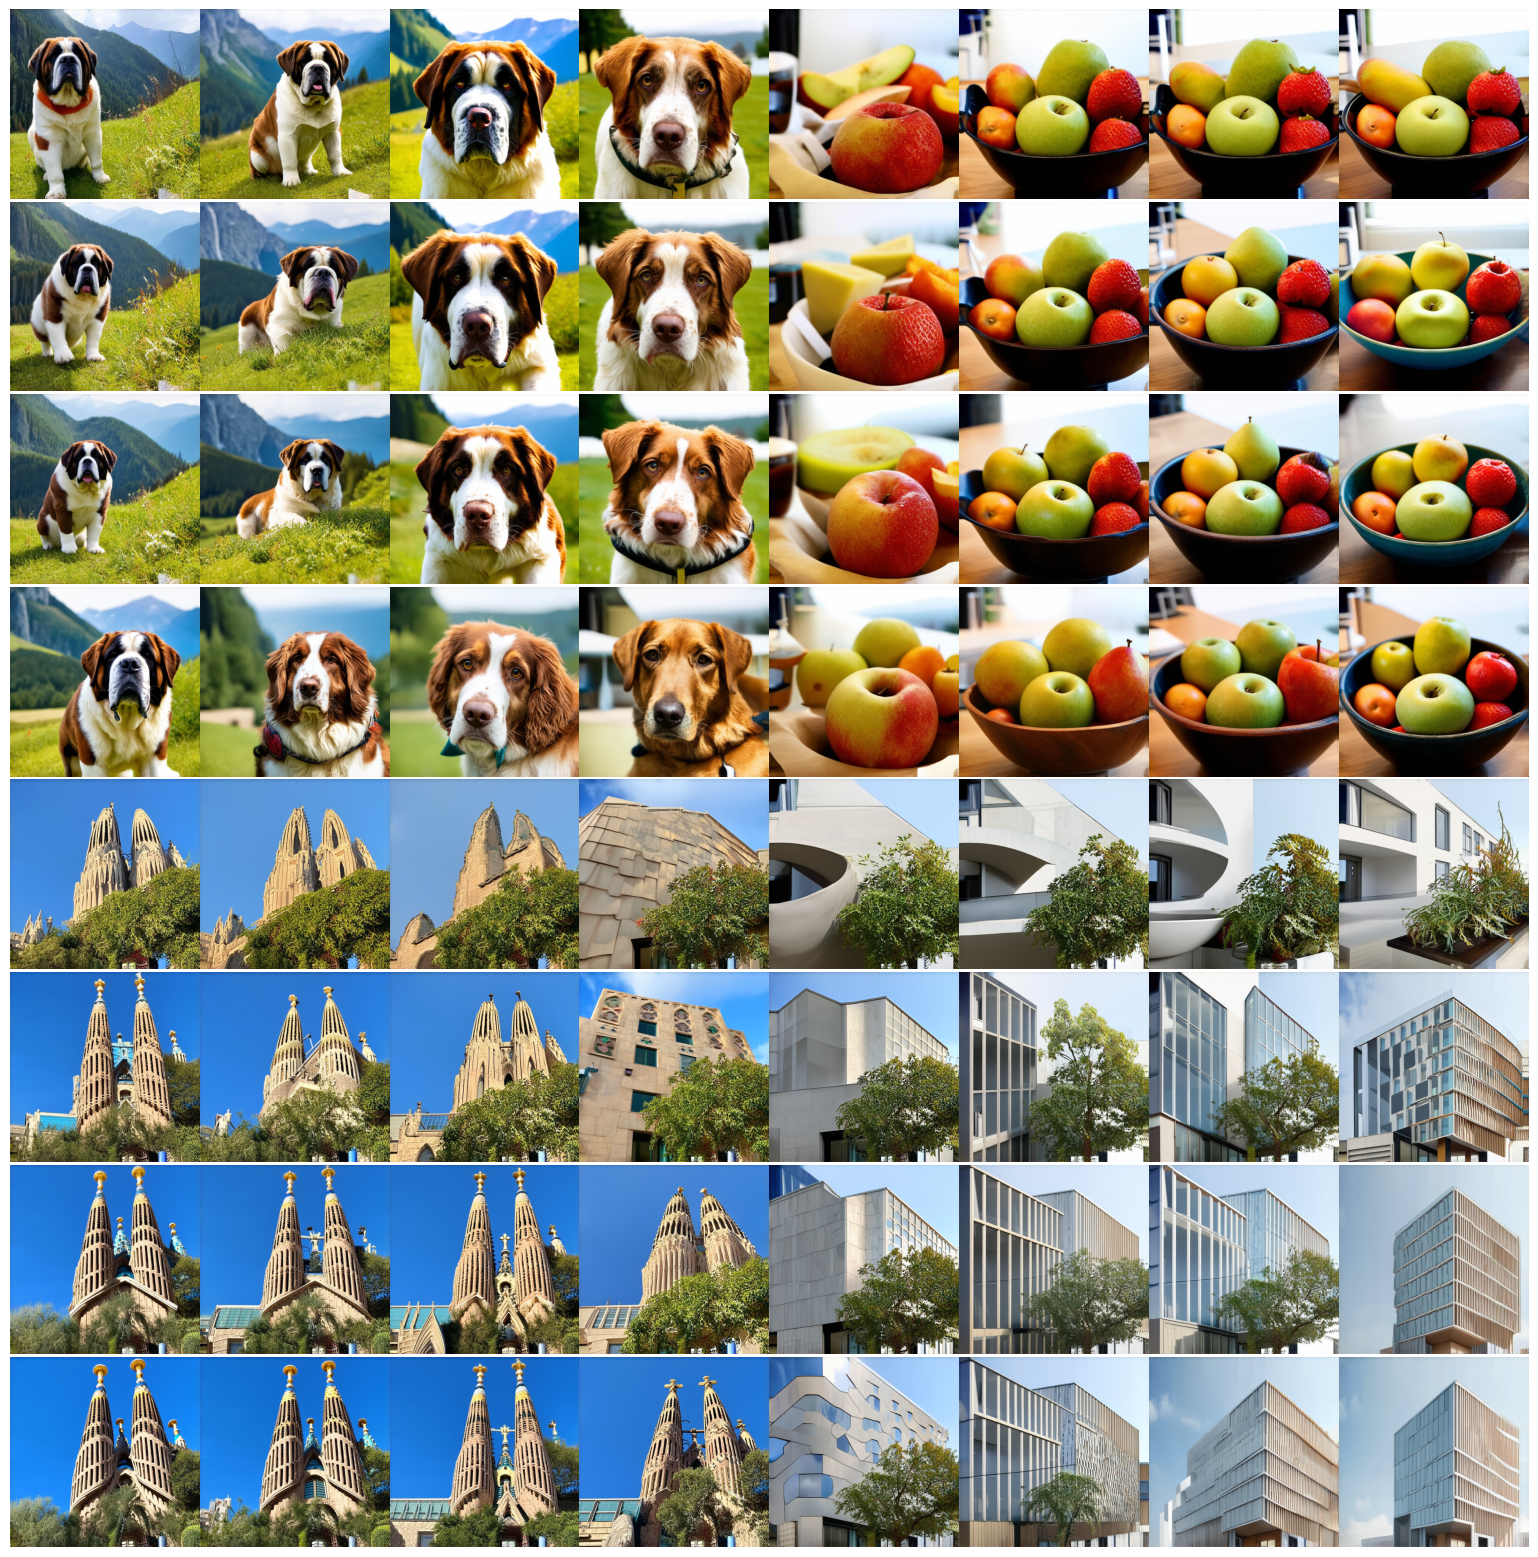

In [10]:
def plot_grid(images, path, grid_size, scale=2):
    fig, axs = plt.subplots(
        grid_size, grid_size, figsize=(grid_size * scale, grid_size * scale)
    )
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis("off")
    for ax in axs.flat:
        ax.axis("off")

    for i in range(min(grid_size * grid_size, len(images))):
        ax = axs.flat[i]
        ax.imshow(images[i])
        ax.axis("off")

    for i in range(len(images), grid_size * grid_size):
        axs.flat[i].axis("off")
        axs.flat[i].remove()

    plt.savefig(
        fname=path,
        pad_inches=0,
        bbox_inches="tight",
        transparent=False,
        dpi=60,
    )


images = ops.convert_to_numpy(decode_to_images(images, height, width))
plot_grid(images, "4-way-interpolation.jpg", interpolation_steps)

# Final conclusion

Without caring about the time execution difference (not mesured and also used the paid version of Google Colab to access the T4 GPU and High-RAM), the final results are really amazing.

The most precised version of the original code really approaches the prompt resulting on a much more accurate images in general terms.

On the other hand, the second example, where the parameters are not as good as the first one, the results are impresive even though there are non related elements or errors that are caused by that 'lack of resources' (random dogs breed, cheese with fruit, random building and a not accurate result for the last prompt about the buildings).